In [63]:
#Importing required Libraries
import pandas as pd
import numpy as np
import math
import gc
from sklearn import preprocessing,model_selection,tree,ensemble,metrics
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [4]:
#loading the train and test files
traindb = pd.read_csv("C:/Users/MK064837/Google Drive/Simplilearn/Python NLP/HR Promotional Analysis/HRtrain.csv")
testdb = pd.read_csv("C:/Users/MK064837/Google Drive/Simplilearn/Python NLP/HR Promotional Analysis/HRtest.csv")

In [5]:
#statistical summary of training dataset
traindb.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [6]:
#Identifying and prnting unique values in each column
def uni(data):
    for i in data:
        print("Unique values in "+i+" are :"+str(data[i].nunique()))
        print("Unique values in "+i+" are :"+str(data[i].sort_values(ascending=True,na_position="last").unique()))

uni(traindb)

Unique values in employee_id are :54808
Unique values in employee_id are :[    1     2     4 ... 78296 78297 78298]
Unique values in department are :9
Unique values in department are :['Analytics' 'Finance' 'HR' 'Legal' 'Operations' 'Procurement' 'R&D'
 'Sales & Marketing' 'Technology']
Unique values in region are :34
Unique values in region are :['region_1' 'region_10' 'region_11' 'region_12' 'region_13' 'region_14'
 'region_15' 'region_16' 'region_17' 'region_18' 'region_19' 'region_2'
 'region_20' 'region_21' 'region_22' 'region_23' 'region_24' 'region_25'
 'region_26' 'region_27' 'region_28' 'region_29' 'region_3' 'region_30'
 'region_31' 'region_32' 'region_33' 'region_34' 'region_4' 'region_5'
 'region_6' 'region_7' 'region_8' 'region_9']
Unique values in education are :3
Unique values in education are :["Bachelor's" 'Below Secondary' "Master's & above" nan]
Unique values in gender are :2
Unique values in gender are :['f' 'm']
Unique values in recruitment_channel are :3
Unique va

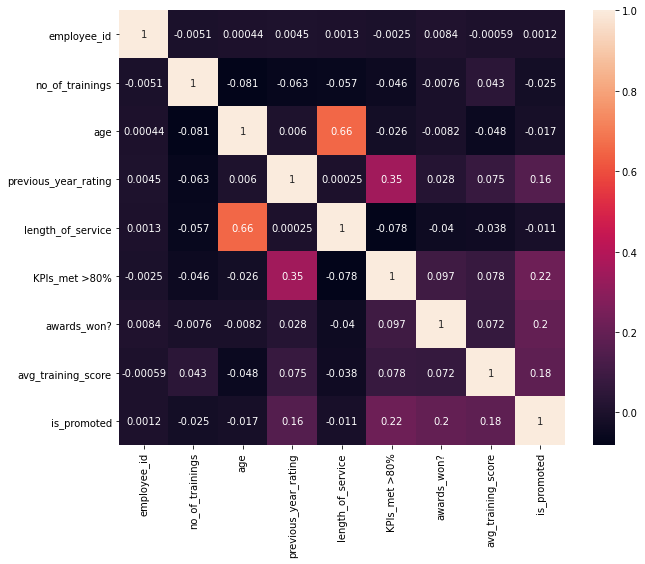

In [9]:
#Variable correlation
plt.figure(figsize=(10,8))
sns.heatmap(traindb.corr(), annot=True)
plt.show()

In [10]:
#Function for cleaning duplicates
def deldup(data):
    print(data.shape)
    data.drop_duplicates(keep='first',inplace=True)
    print(data.shape)
    return "Checked duplicate"

In [11]:
#calling duplication function to clean
deldup(traindb)

(54808, 14)
(54808, 14)


'Checked duplicate'

In [14]:
#Cleaning the previous year ration column for null handling
testdb['previous_year_rating'] = testdb['previous_year_rating'].fillna(0)
traindb['previous_year_rating'] = traindb['previous_year_rating'].fillna(0)

In [17]:
#Cleaning education column for null handling
traindb['education']=traindb['education'].ffill(0)
traindb['education']=traindb['education'].bfill(0)
testdb['education']=testdb['education'].ffill(0)
testdb['education']=testdb['education'].bfill(0)

In [18]:
#Check the sum of null value
print(traindb.isnull().sum())
print(testdb.isnull().sum())

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64
employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64


<AxesSubplot:xlabel='age', ylabel='Count'>

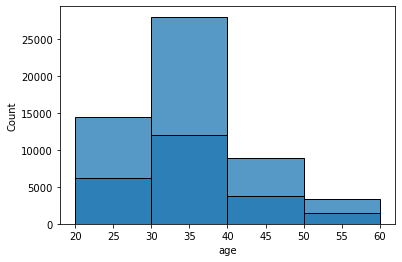

In [20]:
#Plotting age count
sns.histplot(traindb['age'],bins=4)
sns.histplot(testdb['age'],bins=4)

In [21]:
#Train and test data split
X_train = traindb.drop('is_promoted',axis=1)
y_train = traindb['is_promoted']
X_test = testdb

In [26]:
#Defining encoding function for dummy variable and function call
def encoding(edata, ecolumn):
    edata=pd.get_dummies(edata)
    edata.astype('float64').dtypes
    return edata
#Encoding function call
ecolumn = ['department','region','education','gender','recruitment_channel']
X_etrain = encoding(X_train,ecolumn)
X_etest = encoding(X_test,ecolumn)

In [28]:
#Defining scaling function
def scale(sdata,scolumn):
    sdata[scolumn]=RobustScaler().fit_transform(sdata[scolumn])
    return sdata
#scaling the input features
X_strain = scale(X_etrain,X_etrain.columns)
X_stest = scale(X_etest,X_etest.columns)

In [59]:
# Fine Tuned Model With-Hyperparameters :
Classifier = {'0.XGboost': XGBClassifier(learning_rate=0.1,
                                        n_estimators=494,
                                        max_depth=5,
                                        subsample=0.7,
                                        verbosity=0,use_label_encoder=False,
                                        scale_pos_weight=2.5,
                                        updater="grow_histmaker",
                                        base_score=0.2),
             '1.Catboost': CatBoostClassifier(learning_rate=0.15,
                                             n_estimators=494,
                                             subsample=0.08,
                                             max_depth=5,
                                             scale_pos_weight=2.5),
             '2.LightGBM': LGBMClassifier(subsample_freq=2,
                                         objective="binary",
                                         importance_type="gain",
                                         verbosity=-1,
                                         max_bin=60,
                                         num_leaves=300,
                                         boosting_type='dart',
                                         learning_rate=0.15,
                                         n_estimator=494,
                                         max_depth=5,
                                         scale_pos_weight=2.5)}

In [65]:
# Ensemble with Voting Classifier to Improve the  "F1-Score” and Predict Target
voting_model = VotingClassifier(estimators=[('XGBoost_Best',list(Classifier.values())[0]),
                               ('Catboost_Best',list(Classifier.values())[1]),
                               ('LightGBM_Best',list(Classifier.values())[2]),],voting='soft', weights=[5,5,2])
voting_model.fit(X_strain,y_train)
prediction = voting_model.predict(X_stest)

0:	learn: 0.5895589	total: 19.3ms	remaining: 9.51s
1:	learn: 0.4974021	total: 48.4ms	remaining: 11.9s
2:	learn: 0.4554330	total: 72.5ms	remaining: 11.9s
3:	learn: 0.4280343	total: 89.1ms	remaining: 10.9s
4:	learn: 0.3853121	total: 106ms	remaining: 10.4s
5:	learn: 0.3722075	total: 123ms	remaining: 10s
6:	learn: 0.3634578	total: 143ms	remaining: 9.98s
7:	learn: 0.3577791	total: 160ms	remaining: 9.71s
8:	learn: 0.3438193	total: 177ms	remaining: 9.52s
9:	learn: 0.3395904	total: 202ms	remaining: 9.76s
10:	learn: 0.3268587	total: 221ms	remaining: 9.71s
11:	learn: 0.3192888	total: 238ms	remaining: 9.58s
12:	learn: 0.3153603	total: 263ms	remaining: 9.74s
13:	learn: 0.3142554	total: 287ms	remaining: 9.85s
14:	learn: 0.3118020	total: 309ms	remaining: 9.86s
15:	learn: 0.3099867	total: 335ms	remaining: 10s
16:	learn: 0.3050877	total: 362ms	remaining: 10.1s
17:	learn: 0.3008529	total: 382ms	remaining: 10.1s
18:	learn: 0.2960600	total: 407ms	remaining: 10.2s
19:	learn: 0.2953470	total: 426ms	remaini

168:	learn: 0.2461580	total: 3.06s	remaining: 5.89s
169:	learn: 0.2460521	total: 3.09s	remaining: 5.88s
170:	learn: 0.2458977	total: 3.11s	remaining: 5.87s
171:	learn: 0.2457925	total: 3.13s	remaining: 5.86s
172:	learn: 0.2456792	total: 3.15s	remaining: 5.85s
173:	learn: 0.2455723	total: 3.17s	remaining: 5.82s
174:	learn: 0.2454457	total: 3.18s	remaining: 5.8s
175:	learn: 0.2453764	total: 3.21s	remaining: 5.79s
176:	learn: 0.2453228	total: 3.23s	remaining: 5.79s
177:	learn: 0.2452070	total: 3.25s	remaining: 5.78s
178:	learn: 0.2451399	total: 3.28s	remaining: 5.77s
179:	learn: 0.2450190	total: 3.3s	remaining: 5.75s
180:	learn: 0.2449115	total: 3.32s	remaining: 5.74s
181:	learn: 0.2447967	total: 3.34s	remaining: 5.73s
182:	learn: 0.2445053	total: 3.37s	remaining: 5.72s
183:	learn: 0.2444440	total: 3.38s	remaining: 5.7s
184:	learn: 0.2443934	total: 3.4s	remaining: 5.67s
185:	learn: 0.2442820	total: 3.41s	remaining: 5.65s
186:	learn: 0.2442278	total: 3.43s	remaining: 5.63s
187:	learn: 0.24

336:	learn: 0.2313363	total: 6.61s	remaining: 3.08s
337:	learn: 0.2313043	total: 6.62s	remaining: 3.06s
338:	learn: 0.2312716	total: 6.64s	remaining: 3.04s
339:	learn: 0.2311876	total: 6.66s	remaining: 3.02s
340:	learn: 0.2311201	total: 6.68s	remaining: 3s
341:	learn: 0.2310166	total: 6.7s	remaining: 2.98s
342:	learn: 0.2309456	total: 6.72s	remaining: 2.96s
343:	learn: 0.2308971	total: 6.74s	remaining: 2.94s
344:	learn: 0.2307795	total: 6.75s	remaining: 2.92s
345:	learn: 0.2307194	total: 6.77s	remaining: 2.9s
346:	learn: 0.2306564	total: 6.78s	remaining: 2.87s
347:	learn: 0.2305453	total: 6.79s	remaining: 2.85s
348:	learn: 0.2304991	total: 6.81s	remaining: 2.83s
349:	learn: 0.2304522	total: 6.83s	remaining: 2.81s
350:	learn: 0.2304151	total: 6.86s	remaining: 2.79s
351:	learn: 0.2303683	total: 6.89s	remaining: 2.78s
352:	learn: 0.2303049	total: 6.92s	remaining: 2.76s
353:	learn: 0.2302292	total: 6.94s	remaining: 2.75s
354:	learn: 0.2301594	total: 6.97s	remaining: 2.73s
355:	learn: 0.230

In [69]:
#Prediction the employee's having chance to be promotedT
prediction=[int(round(value)) for value in prediction]
Result_Promoted = pd.DataFrame({'Employee_ID':testdb.employee_id,'is_promoted':prediction})
Result_Promoted.query('is_promoted==1')

,Employee_ID,is_promoted
9,76303,1
32,67672,1
78,10732,1
118,27495,1
122,3901,1
...,...,...
23369,76747,1
23382,5452,1
23387,29019,1
23454,55030,1
